# Solving a mincost k-SAT problem using QAOA

Before looking at this notebook, you should understand the methods described in the qaoa_mincost_sat notebook, as we will consider those as given here.
With the methods described in the qaoa_mincost_sat notebook, we are only able to solve 2-SAT problems, because we transform our SAT problem to a QUBO problem, which is limited to quadratic terms, and then implement the corresponding Ising model in a quantum circuit.
While there are methods for quadratization of Higher Order Binary Optimization (HOBO) problems, meaning a transformation to a QUBO problem, they introduce auxiliary variables and thus require additional qubits.

The following describes, how to convert an arbitrary SAT problem to a HOBO problem and how to implement the corresponding problem circuit for applying QAOA, while using the same number of qubits as there are boolean variables in the SAT term and using a circuit depth that grows linear in the number of variables and degree of the SAT problem.

The system, we will use as an example in this notebook, is described by the following boolean formular:
$
(x_1 \vee x_2) \wedge (x_2 \vee \neg x_3 \vee x_4) \wedge (x_3 \vee \neg x_5 \vee \neg x_6)
$

We will use the same implementation cost for each feature as in the other notebook:

| Feature | Cost $c_i$ |
|---------|------------|
| $x_1$   | 30         |
| $x_2$   | 20         |
| $x_3$   | 25         |
| $x_4$   | 50         |
| $x_5$   | 10         |
| $x_6$   | 10         |

## Converting k-SAT to HOBO

For clauses containing two variables, we can just use the quadratic penalties described by [Glover](https://arxiv.org/abs/1811.11538) we also used in the other notebook:

| Clause Type   | Example                          | Constraint                   | Penalty                       |
|---------------|----------------------------------|------------------------------|-------------------------------|
| No Negations  | $$(x_i \vee x_j)$$               | $$x_i + x_j \geq 1$$         | $$(1 - x_i - x_j + x_i x_j)$$ |
| One Negation  | $$(x_i \vee \lnot{}x_j)$$        | $$x_i + (1-x_j) \geq 1$$     | $$(x_j - x_i x_j)$$           |
| Two Negations | $$(\lnot{}x_i \vee \lnot{}x_j)$$ | $$(1-x_i) + (1-x_j) \geq 1$$ | $$(x_i x_j)$$                 |

For clauses containing $k \ge 3$ variables, we can apply the penalties recursively.

$$(x_i \vee x_j \vee x_k) = ((x_i \vee x_j) \vee x_k)$$

We first apply the quadratic penalty to $(x_i \vee x_j)$.
The resulting penalty can be seen as a new variable $x_{ij}$ that is 0 exactly when $(x_i \vee x_j)$ is fulfilled and 1 otherwise, meaning $x_{ij} = \neg(x_i \vee x_j)$
Using that, we can define the boolean funktion as

$$(x_i \vee x_j \vee x_k) = (x_k \vee \neg x_{ij})$$

which we can again transform using the given quadratic penalties as follows:

$$
(x_{ij} - x_k x_{ij})\\
= ((1 - x_i - x_j + x_i x_j) - x_k (1 - x_i - x_j + x_i x_j))\\
= (1 - x_i - x_j + x_i x_j - x_k + x_i x_k + x_j x_k - x_i x_j x_k)\\
= (1 - x_i - x_j - x_k + x_i x_j + x_i x_k + x_j x_k - x_i x_j x_k)
$$

The same principle can be applied for clauses with negations or more variables.

Using this method we can transform our example into the corresponding HOBO model.

$$
min~y(x) = (1- x_1 - x_2 + x_1 x_2) + (x_3 - x_2 x_3 - x_3 x_4 + x_2 x_3 x_4) + (x_5 x_6 - x_3 x_5 x_6)\\
= 1 - x_1 - x_2 + x_3 + x_1 x_2 - x_2 x_3 - x_3 x_4 + x_5 x_6 + x_2 x_3 x_4 - x_3 x_5 x_6
$$

We can now transform this HOBO model into an Ising model

$$
min~y(x) = 1 - \frac{1 -s_1}{2} - \frac{1 - s_2}{2} + \frac{1 - s_3}{2} + \frac{1 - s_1}{2} \frac{1 - s_2}{2} - \frac{1 - s_2}{2} \frac{1 - s_3}{2} - \frac{1 - s_3}{2} \frac{1 - s_4}{2} + \frac{1 - s_5}{2} \frac{1 - s_6}{2} + \frac{1 - s_2}{2} \frac{1 - s_3}{2} \frac{1 - s_4}{2} - \frac{1 - s_3}{2} \frac{1 - s_5}{2} \frac{1 - s_6}{2}\\
= 1 + s_1 \frac{1}{2} + s_2 \frac{1}{2} - s_3 \frac{1}{2} - s_1 s_2 \frac{1}{4} + s_2 s_3 \frac{1}{4} + s_3 s_4 \frac{1}{4} - s_5 s_6 \frac{1}{4} - s_2 s_3 s_4 \frac{1}{8} + s_3 s_5 s_6 \frac{1}{8}\\
$$

Which leaves us with the following cost hamiltonian $H_C$:

$$
H_C = 1 * I + \sigma_1^z \frac{1}{2} + \sigma_2^z \frac{1}{2} - \sigma_3^z \frac{1}{2} - \sigma_1^z \sigma_2^z \frac{1}{4} + \sigma_2^z \sigma_3^z \frac{1}{4} + \sigma_3^z \sigma_4^z \frac{1}{4} - \sigma_5^z \sigma_6^z \frac{1}{4} - \sigma_2^z \sigma_3^z \sigma_4^z \frac{1}{8} + \sigma_3^z \sigma_5^z \sigma_6^z \frac{1}{8}
$$

## Quantum Circuit

We start by defining a parametrized circuit.
We will skip the details of initialization and implementing the mixing operator, as they are the same as in the other notebook.

In [17]:
# Notebook Setup
from IPython.core import page
page.page = print

# Imports used for examples
from pprint import pprint

### Phase-separating operator
Like in the other notebook, the phase-separating operator $U(C,\gamma)$ encodes $C$ and can be derived from a cost Hamiltonian $H_{Ctot}$ in Ising-form.
Unlike in the other notebook, there is now the possibility of having terms of degree higher than 2 in the cost function, for which we need to implement the corresponding $R_{z ... z}$ gates.
We do this by decomposing the $R_{z ... z}$ gate into multiple CNOT gates and a single $R_z$ gate.


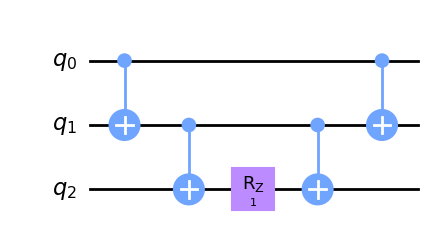

In [18]:
# R_{zzz} gate
from qaoa_mincost_k_sat import k_rz_gate
from qiskit import QuantumCircuit

qubits = [0, 1, 2]
qc = QuantumCircuit(len(qubits))
qc_zzz = k_rz_gate(qc, qubits, 1)
qc_zzz.draw(output='mpl')

Using this implementation of general $R_{z ... z}$ gates, we can now implement the phase-separating operator for our example.

In [19]:
# Hamiltonians may be described as a dict of tuples describing acting qubits and a value for each clause
# hamiltonian = {(q1?, q2?, ...) : factor}
sat_hamiltonian = {
    (): 1,
    (0,): 0.5,
    (1,): 0.5,
    (2,): -0.5,
    (0, 1): -0.25,
    (1, 2): 0.25,
    (2, 3): 0.25,
    (4, 5): -0.25,
    (1, 2, 3): -0.125,
    (2, 4, 5): 0.125
}

In [20]:
from qaoa_mincost_k_sat import problem_circuit
%psource problem_circuit

def problem_circuit(hamiltonian: DictArithmetic, nqubits: int) -> tuple[QuantumCircuit, Parameter]:
    """
        Creates a quantum circuit for the given hamiltonian

        :param hamiltonian: The hamiltonian to create the circuit for
        :param nqubits: The number of qubits to create the circuit for
    """
    gamma = Parameter("$\\gamma$")
    qc_p = QuantumCircuit(nqubits)
    normalization = math.pi/max(hamiltonian.values())

    for key, factor in hamiltonian.items():
        qc_p.compose(k_rz_gate(qc_p, list(key), 2 * normalization * factor * gamma))

    return qc_p, gamma



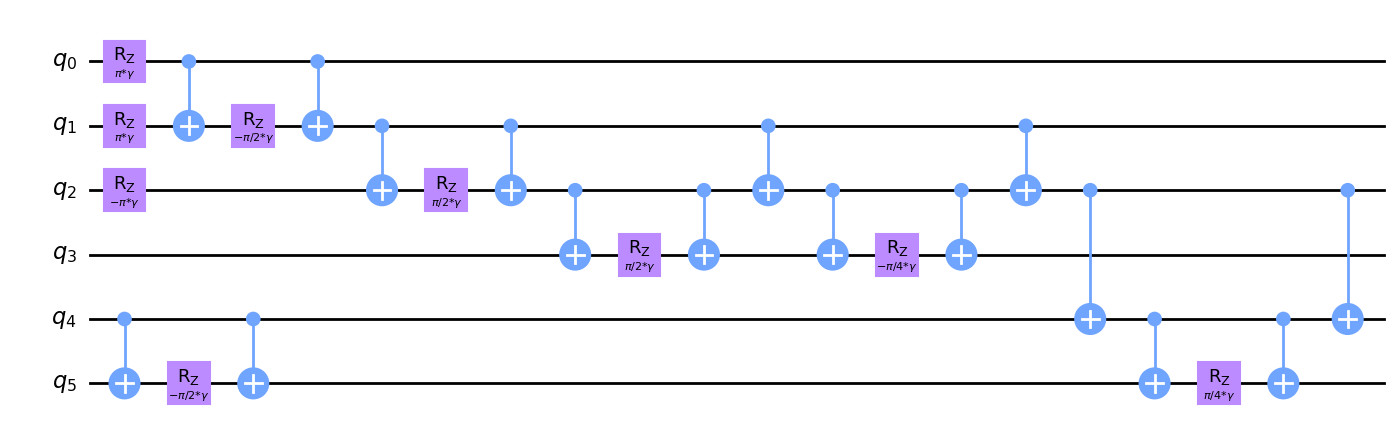

In [21]:
example_qc_problem, _ = problem_circuit(sat_hamiltonian, 6)
example_qc_problem.draw(output='mpl')

In [22]:
# cost and sat individually
from qubovert import boolean_var

# define binary vars
x1, x2, x3, x4, x5, x6 = boolean_var('x1'), boolean_var('x2'), boolean_var('x3'), boolean_var('x4'), boolean_var('x5'), boolean_var('x6')

# SAT Penalty
alpha_sat = 500 # 1e6

# SAT HOBO
sat_model = alpha_sat * (1 - x1 - x2 + x3 + x1*x2 - x2*x3 - x3*x4 + x5*x6 + x2*x3*x4 - x3*x5*x6)

# Cost HOBO
cost_model = 30*x1 + 20*x2 + 25*x3 + 50*x4 + 10*x5 + 10*x6

# Combine models
combined_model = sat_model +  cost_model
print("HOBO Combined Model:")
pprint(combined_model)
print("Ising Combined Model: ")
combined_hamiltonian = combined_model.to_puso()
pprint(combined_hamiltonian)

HOBO Combined Model:
{(): 500,
 ('x1',): -470,
 ('x1', 'x2'): 500,
 ('x2',): -480,
 ('x2', 'x3'): -500,
 ('x2', 'x3', 'x4'): 500,
 ('x3',): 525,
 ('x3', 'x4'): -500,
 ('x3', 'x5', 'x6'): -500,
 ('x4',): 50,
 ('x5',): 10,
 ('x5', 'x6'): 500,
 ('x6',): 10}
Ising Combined Model: 
{(): 322.5,
 (0,): 110.0,
 (0, 1): 125.0,
 (1,): 177.5,
 (1, 2): -62.5,
 (1, 2, 3): -62.5,
 (1, 3): 62.5,
 (2,): -12.5,
 (2, 3): -62.5,
 (2, 4): -62.5,
 (2, 4, 5): 62.5,
 (2, 5): -62.5,
 (3,): 37.5,
 (4,): -67.5,
 (4, 5): 62.5,
 (5,): -67.5}


In [23]:
from qaoa_application import apply_qaoa
from qaoa_mincost_k_sat import problem_circuit

hamiltonian = combined_hamiltonian
layers = 60 # more layers = higher approximation rate but more quantum errors when running on real qpu
n_features = 6
shots = 256
theta = {"beta": 0.01, "gamma": -0.01} # start values for optimization
use_warmstart = False
use_optimizer = True

if not use_warmstart:
    warmstart_statevector = None

counts, qc = apply_qaoa(problem_circuit, hamiltonian, layers, n_features, shots, theta, warmstart_statevector, use_optimizer)

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [ ]:
from configproblem.util.visualization import plot_counts_histogram

best_config = "000010" # 654321
valid_configs = ["111111", "011111", "101111", "001111", "110111", "010111", "100111", "000111", "011011", "101011", "001011", "010011", "100011", "000011", "111101", "011101", "101101", "001101", "011001", "101001", "001001", "010001", "100001", "000001", "111110", "011110", "101110", "001110", "110110", "010110", "100110", "000110", "011010", "101010", "010010", "100010", "000010"]

plot_counts_histogram(counts, best_config, valid_configs)